# XANES Analysis
This example covers:
1. Read processed data
2. Read standards
3. Recalibrate data
4. XANES analysis
5. Save processed data

Reading is shown using processed data in previous notebook and data from the article. The data comes from Athena project files.

After reading the data is presented as a plot.

XANES is performed by plotting the standards and the data together to enable comparison.


## Resources
Pyhon modules and libraries used in this example

In [1]:
# code for importing custom helper libraries
import sys
# moved all custom helper libraries to a level bellow this directory.
sys.path.append('../lib/')

# Library with the functions that provide the larch functionalities
# equivalent to those provided by athena including normalisation, 
# merging, re-binning, LCF and visualisation (plotting)
import manage_athena as athenamgr 

# additional custom plot functions (replicate plots in published papers)
import custom_plots

# File handling
from pathlib import Path

# Handling json files
import json

# printing formated json data
import pprint

# to copy the mutable types like dictionaries, use copy/deepcopy 
import copy

#plotting library
import matplotlib.pyplot as plt
# inline: shows plot in notebook
# tk: shows plot in popup
%matplotlib inline 

# 1. Read data

The process is divided in two steps. The first step entails reading the metadata which indicates the location of the data and some additional parameters such as group names and file mappings. The second step uses this metadata to retrieve the process data from the files indicated in the metadata.

## 1.1 Data mappings

Variables used for mapping processed data to results in paper. In this case these data are for figure 4A. The mappings are stored in a json file which is a copy of the one produced in the previous step named "PtSn_KEdge_processed.json", but also includes additional data which points to the standards used for XANES analyses.


In [2]:
json_file = "./mappings_metadata.json"
json_metadata = {}

with open(json_file) as json_data:
    json_metadata = json.load(json_data)

pprint.pprint(json_metadata)

json_file = "operations_metadata.json"
operations_data = {}
print("*"*80)
with open(json_file) as json_data:
    operations_data = json.load(json_data)
    
pprint.pprint(operations_data)

{'data_file': 'Xray_data.zip',
 'data_mapping': [{'data_path': '../outputs/PtSn_KEdge',
                   'data_type': 'athena',
                   'file_mappings': [{'file_name': 'PtSn_KEdge_processed.prj',
                                      'group': 'PtSn',
                                      'group_name': 'PtSn'},
                                     {'file_name': 'PtSn_KEdge_processed.prj',
                                      'group': 'Air',
                                      'group_name': 'Air'},
                                     {'file_name': 'PtSn_KEdge_processed.prj',
                                      'group': 'Ar',
                                      'group_name': 'Ar'},
                                     {'file_name': 'PtSn_KEdge_processed.prj',
                                      'group': 'H2',
                                      'group_name': 'H2'},
                                     {'file_name': 'PtSn_KEdge_processed.prj',
                     

## 1.2 Read data

The process below reads the data from the output file generated in the previous step and collects the groups in a dictionary for further processing and analysis. Additionally it also reads the two standards used for XANES. All the data comes from athena files.


In [3]:
snkedge_data={}

# read all samples, merge and then normalise


for a_set in json_metadata["data_mapping"]:
    project_path = Path(a_set["data_path"])
    for a_mapping in a_set["file_mappings"]:
        
        
        # project file name
        project_name = a_mapping['file_name']
        # name assigned to the readings for processing and display
        data_group =  a_mapping['group']    
        # the group names use underscores instead of spaces and periods 
        # in athena file
        group_name =  a_mapping['group_name']
        # read each group from the corresponding project file
        athena_project = athenamgr.read_project(Path(project_path,project_name))
        
        snkedge_data[data_group] = athenamgr.get_group(athena_project, group_name)
        snkedge_data[data_group].filename = data_group

Just to check we plot the data collected so far 

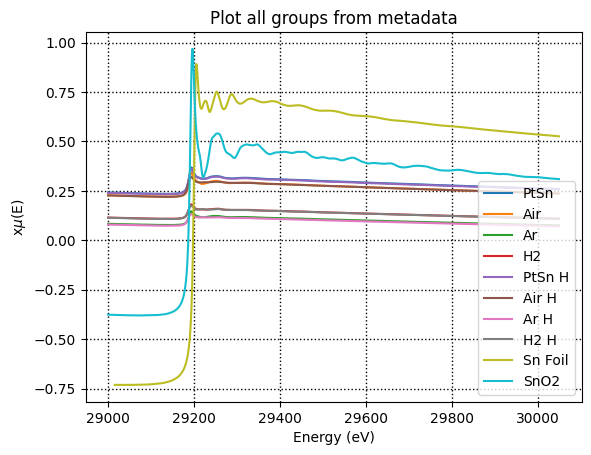

In [4]:
for a_group in snkedge_data:
   plt = athenamgr.plot_mu(snkedge_data[a_group])

plt.title("Plot all groups")
plt.show()

# 2. Recalibrate data
The article indicates that the data is calibrated taking E0 from the standard (Sn Foil).
The code shows data before recalibration and then the results after recalibration (zooming on the E0 region)

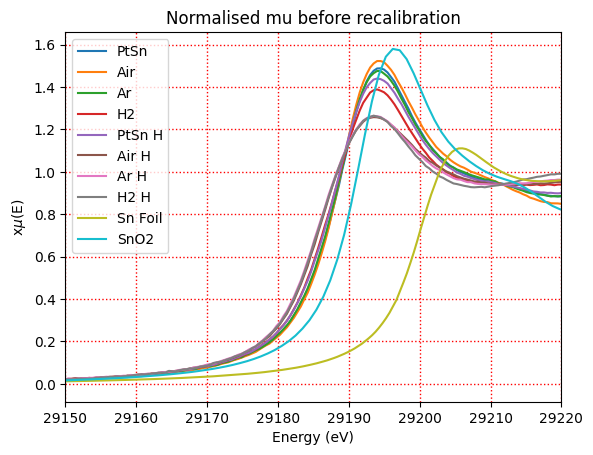

Will recalibrate all signals to : 29200.142 Sn Foil


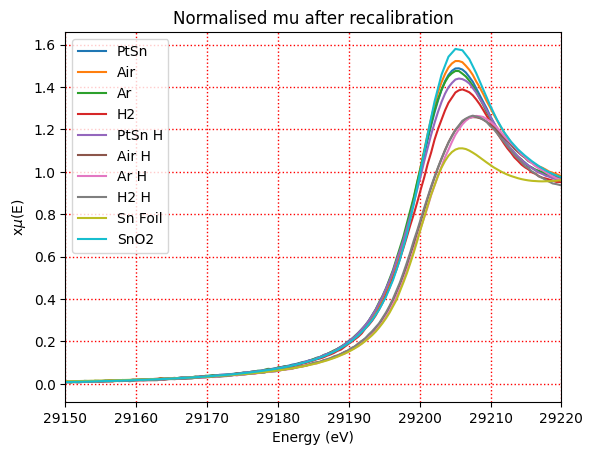

In [5]:
# get parameters for the first operation
reference_group = operations_data['task_list'][0]['variables']["reference_standard"]
x_min = operations_data['task_list'][0]['variables']["x_min"]
x_max = operations_data['task_list'][0]['variables']["x_max"]


# plot data
for a_group in snkedge_data:
   plt = athenamgr.plot_normalised(snkedge_data[a_group])

plt.title("Normalised mu before recalibration")
plt.xlim([x_min, x_max])
plt.show()

# get E0 from reference standard

standard_e0 = athenamgr.get_group_e0(snkedge_data[reference_group])

print("Will recalibrate all signals to :", standard_e0, reference_group)

# recalibrate the standard E0
for a_sample in snkedge_data:
    snkedge_data[a_sample] = athenamgr.recalibrate_energy(snkedge_data[a_sample], standard_e0)

# plot data after recalibration
for a_group in snkedge_data:
   plt = athenamgr.plot_normalised(snkedge_data[a_group])

plt.title("Normalised mu after recalibration")
plt.xlim([x_min, x_max])
plt.show()

# 3. XANES analysis

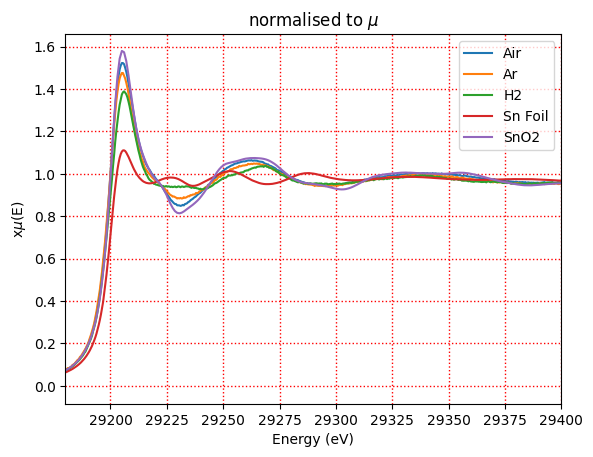

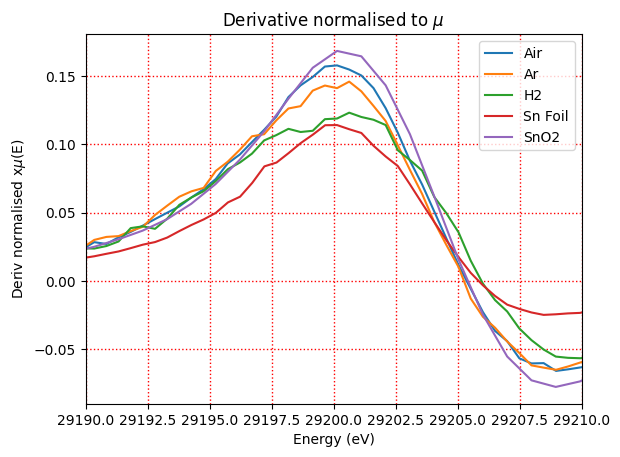

In [6]:
# get parameters for the second operation 
plot_groups = operations_data['task_list'][1]['variables']["plot_groups"]

x_min = operations_data['task_list'][1]['variables']["x_min"]
x_max = operations_data['task_list'][1]['variables']["x_max"]

for a_sample in snkedge_data:
    if a_sample in plot_groups:
        plt = athenamgr.plot_normalised(snkedge_data[a_sample])
    
plt.xlim([x_min, x_max])
plt.show()

# get parameters for the third operation 
plot_groups = operations_data['task_list'][2]['variables']["plot_groups"]

x_min = operations_data['task_list'][2]['variables']["x_min"]
x_max = operations_data['task_list'][2]['variables']["x_max"]

for a_sample in snkedge_data:
    if a_sample in plot_groups:
        plt = athenamgr.plot_derivative(snkedge_data[a_sample])
    
plt.xlim([x_min, x_max])
plt.show()

# 4. Save data
The saving process is also divided in two steps, first the data is saved into an athena project, and then the corresponding  metadata is saved in a json file.

## 4.1 Save Athena project
Store processed data in an Athena project file

In [7]:
# get parameters for the fourth operation 
# define the location of the output files
out_prefix =  operations_data['task_list'][3]['variables']["out_prefix"]
out_location = operations_data['task_list'][3]['variables']["out_location"]
# create a new output dir if it does not exist
out_dir = athenamgr.set_out_dir(out_prefix,out_location)
out_file = out_prefix+"_xanes.prj"
# save the data to that output dir
athenamgr.save_groups(snkedge_data.values(), Path(out_dir, out_file))
print("data saved to", str(Path(out_dir, out_file)))

data saved to ..\outputs\PtSn_KEdge\PtSn_KEdge_xanes.prj


## 4.2 Save mappings
Store the metadata required to support further processing.

In [8]:
# save a json file with the results
# using the structure of the initial data mappings
out_mappings = copy.deepcopy(json_metadata)

new_mappings = {}
file_mappings = []
for a_sample in snkedge_data:
    file_mappings.append ({'group':a_sample, 
                           'group_name':a_sample.replace(" ","_"),
                           'file_name': out_file.replace("\\","/")})

new_mappings['data_path'] = str(out_dir).replace("\\","/")
new_mappings['data_type'] = "athena"
new_mappings['file_mappings'] = file_mappings

out_mappings['data_mapping'].append(new_mappings)


json_data = json.dumps(out_mappings, indent=4)
out_file_name = Path(out_dir, out_prefix+'_xanes.json')
with open(out_file_name, 'w', encoding='utf-8') as f:
    f.write(json_data)
print("Mapping data saved to:", str(out_file_name))


Mapping data saved to: ..\outputs\PtSn_KEdge\PtSn_KEdge_xanes.json


## References

The data used in this example is part of the supporting data for:

Huang, Haoliang, Nassr, Abu Bakr Ahmed Amine, Celorrio, Verónica, Taylor, S. F. Rebecca, Puthiyapura, Vinod Kumar, Hardacre, Christopher, Brett, Dan J. L., Russell, Andrea E. (2018) Effects of heat treatment atmosphere on the structure and activity of Pt3Sn nanoparticle electrocatalysts: a characterisation case study. Faraday Discussions. V. 208. pp. 555-573. DOI:[10.1039/c7fd00221a](http://doi.org/10.1039/c7fd00221a).

The data used for reproducing the results was published in the Southampton Instituional Repository DOI: [10.5258/SOTON/D0408](https://eprints.soton.ac.uk/421798/), with the name Xray_data.zip - Dataset.